# Temporary SPT Simple Model 

In [2]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import seaborn as sns
import math
import os
import sys
import emcee
import pandas as pd
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
%matplotlib inline

## Creating a Simple Model via Simulated Data

In [5]:
sigma_chisi, sigma_lbd = 0.16, 0.169
rho = 0.79
Nclusters = 100000

# Cluster is defined as Mass (M) and redshift (z)

In [6]:
mfakes = 10**(np.random.uniform(14,15.2, size=Nclusters))
zfakes = np.random.uniform(0.1, 1.3, size=Nclusters)
# No "10^" for zfakes?
# Creating Nclusters number of fake mass 
# and redshift samples that are uniformly distributed

In [7]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

p_halos = halo_mass_function(mfakes, zfakes)

indices_halos = np.random.choice(Nclusters, size = 1000, p = (p_halos/(np.sum(p_halos))))
# size = Nclusters/100 or 100,000/100 = 1000

In [8]:
# The creation of the fake samples for redshift and mass
# by chnaging the distribution from uniform to parabolic
zsims = zfakes[indices_halos]
msims = mfakes[indices_halos]

In [9]:
M0 = 3e14
Ez0 = E(0)

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

ln_zeta_true = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], msims, zsims)
ln_lambda_true = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], msims, zsims)

#mean = [lbd_true, zeta_true]

In [10]:
# To correlate them:
Cov = np.matrix(([sigma_lbd**2, rho*sigma_lbd*sigma_chisi], [rho*sigma_lbd*sigma_chisi, sigma_lbd**2]))

# for a given cluster: msims, zsims

ln_lambda, ln_zeta = [], []
for i in range(len(ln_lambda_true)):
    ln_lambdai, ln_zetai = np.random.multivariate_normal([ln_lambda_true[i],ln_zeta_true[i]],cov=Cov)
    ln_lambda.append(ln_lambdai)
    ln_zeta.append(ln_zetai)
    
# Final dataset --> (zsims, msims, ln_lambda, ln_zeta, ln_lambda_true, ln_zeta_true)

In [11]:
# Changes the size of the graph and font
from scipy.optimize import curve_fit

sns.set_theme(style="darkgrid")
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [12]:
#log_msims = np.log(msims/M0)

#x1 = log_msims
#y1 = ln_lambda

#f=lambda x,a,b: a*x + b
#fit=curve_fit(f, x1, y1)
#xsmooth=np.linspace(np.min(x1), np.max(x1), 1000)
#plt.plot(x1,y1,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
#plt.xlabel('Log of Simulated Mass')
#plt.ylabel('Log of Richness')
#plt.legend()

# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of lambda based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

#plt.plot(x1, ln_lambda_true, 'k--', label='Truth', alpha = 0.8)

#print('Combination of Slope and Y-Intercept:', fit[0])
#print('Slope:', fit[0][0])
#print('Y-Intercept:', fit[0][1])

In [13]:
#x2 = log_msims
#y2 = ln_zeta

#f=lambda x,a,b: a*x + b
#fit=curve_fit(f, x2, y2)
#xsmooth=np.linspace(np.min(x2), np.max(x2), 1000)
#plt.plot(x2,y2,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
#plt.xlabel('Log of Simulated Mass')
#plt.ylabel('Log of Redshift')
#plt.legend()


# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of zeta based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

#plt.plot(x1, ln_zeta_true, 'k--', label='Truth', alpha = 0.8)

#print('Combination of Slope and Y-Intercept:', fit[0])
#print('Slope:', fit[0][0])
#print('Y-Intercept:', fit[0][1])

In [14]:
out = dict()
out['z'] = zsims
out['M'] = msims
out['lambda'] = np.exp(ln_lambda)
out['zeta'] = np.exp(ln_zeta)
out['lambda_true'] = np.exp(ln_lambda_true)
out['zeta_true'] = np.exp(ln_zeta_true)

df = pd.DataFrame(out, columns = ['z', 'M', 'lambda', 'zeta', 'lambda_true', 'zeta_true'])
print(df)

#df.to_csv('fake_data_Jun21.csv', index=False)
# pd.DataFrame.to_csv('fake_data_Jun21.csv')

            z             M     lambda      zeta  lambda_true  zeta_true
0    0.293661  1.398978e+14  41.603109  2.125600    36.824291   1.738582
1    0.121506  1.976367e+14  53.816632  3.269492    51.056866   2.834802
2    0.238207  1.037707e+14  34.103137  1.226484    26.920763   1.084479
3    0.451736  1.896814e+14  51.902861  3.210492    51.530589   2.889120
4    0.687147  1.235951e+14  31.961629  1.630154    34.635795   1.595847
..        ...           ...        ...       ...          ...        ...
995  0.292721  1.392204e+14  57.275639  2.762610    36.637032   1.725277
996  0.236848  1.358645e+14  33.167131  1.394419    35.429880   1.639093
997  0.418081  1.726962e+14  43.662099  2.570504    46.569677   2.479767
998  1.039136  1.121039e+14  40.576561  1.532907    33.266971   1.510825
999  0.665490  1.573428e+14  55.420257  3.219414    44.143889   2.297543

[1000 rows x 6 columns]


In [15]:
#df0 = df.copy()
#display(df0)

In [16]:
#zeta = df0.zeta.to_numpy()
#zetacut = zeta > 5
#df = df0.loc[zetacut].copy()

#display(df)

In [17]:
df.to_csv(r'C:\MuStar_Project\mustar-summar-project\simple_model\fake_data_Jun21.csv', index=False)

# Creating an MCMC Model

Using the Simple Model Likelihood in order to see how accurate the predicted MCMC values are from the known true values

In [18]:
display(df)

,z,M,lambda,zeta,lambda_true,zeta_true
0,0.293661,1.398978e+14,41.603109,2.125600,36.824291,1.738582
1,0.121506,1.976367e+14,53.816632,3.269492,51.056866,2.834802
2,0.238207,1.037707e+14,34.103137,1.226484,26.920763,1.084479
3,0.451736,1.896814e+14,51.902861,3.210492,51.530589,2.889120
4,0.687147,1.235951e+14,31.961629,1.630154,34.635795,1.595847
...,...,...,...,...,...,...
995,0.292721,1.392204e+14,57.275639,2.762610,36.637032,1.725277
996,0.236848,1.358645e+14,33.167131,1.394419,35.429880,1.639093
997,0.418081,1.726962e+14,43.662099,2.570504,46.569677,2.479767
998,1.039136,1.121039e+14,40.576561,1.532907,33.266971,1.510825


In [19]:
#ix = np.where((np.array(df['lambda']))>5)[0] # take 100 points
#Np = ix.size
#yerr = 0.05*(df['lambda'].to_numpy())
#redshift = (np.array(df['z']))[ix]
#sz_signal = (np.array(df['zeta']))[ix]
#_lambda = (np.array(df['lambda']))[ix]
#mass = np.array(df['M'])[ix]

mask = (df['lambda']>5)&(df['zeta']>3)
### Changed the lower limit for zeta from 3 to 5 (since the minimum value setup for zeta is 5) ###
### Changed once more to 3 since the number of points dropped to half of its previous size (from ~340 to ~170)
### causing the corner plot to be far too inaccurate
## Now that the data points have been doubled (to 645) should we be consistent?
ix = np.where(mask)[0]
Np = ix.size

yerr = 0.05*(df['lambda'].to_numpy())

redshift = (np.array(df['z']))[ix]
sz_signal = (np.array(df['zeta']))[ix]
_lambda = (np.array(df['lambda']))[ix]
_lambda_error = (np.array(yerr))[ix]
mass = (np.array(df['M']))[ix]

print('Number of points',Np)

Number of points 321


In [20]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)
# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(np.array(df['lambda'])))[(np.array(df['lambda']))>0][np.argmax(np.array(df['lambda'])[np.array(df['lambda'])>0])]

redshift_i = (np.array(df['z']))[ix]
print("This is the redshift_i:", redshift_i)
sz_signal_i = (np.array(df['zeta']))[ix]
print("This is the sz_signal_i:", sz_signal_i)
_lambda_i = (np.array(df['lambda']))[ix]
print("This is the _lambda_i:", _lambda_i)
_lambda_error_i = (np.array(yerr))[ix]
print("This is the _lambda_error_i:", _lambda_error_i)

This is the redshift_i: 0.12671508988678398
This is the sz_signal_i: 48.431529277679395
This is the _lambda_i: 330.22195524853487
This is the _lambda_error_i: 16.511097762426743


In [21]:
x = np.vstack([mass, redshift])
print("This is the combined x vector of mass and redshift shape:", x.shape)
y = np.vstack([_lambda, sz_signal])
print("This is the combined y vector of lambda and zeta shape:", y.shape)

This is the combined x vector of mass and redshift shape: (2, 321)
This is the combined y vector of lambda and zeta shape: (2, 321)


In [22]:
eps = 1e-9
lbd = _lambda[0]
zeta = sz_signal[0]

print("This is the first value of lambda:", lbd)
print("This is the first value of zeta:", zeta)

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

This is the first value of lambda: 53.8166321455485
This is the first value of zeta: 3.2694919328243333


(array([295., 245., 178., 106.,  80.,  43.,  31.,  15.,   3.,   2.]),
 array([14.00005689, 14.10382361, 14.20759034, 14.31135706, 14.41512379,
        14.51889051, 14.62265723, 14.72642396, 14.83019068, 14.93395741,
        15.03772413]),
 <BarContainer object of 10 artists>)

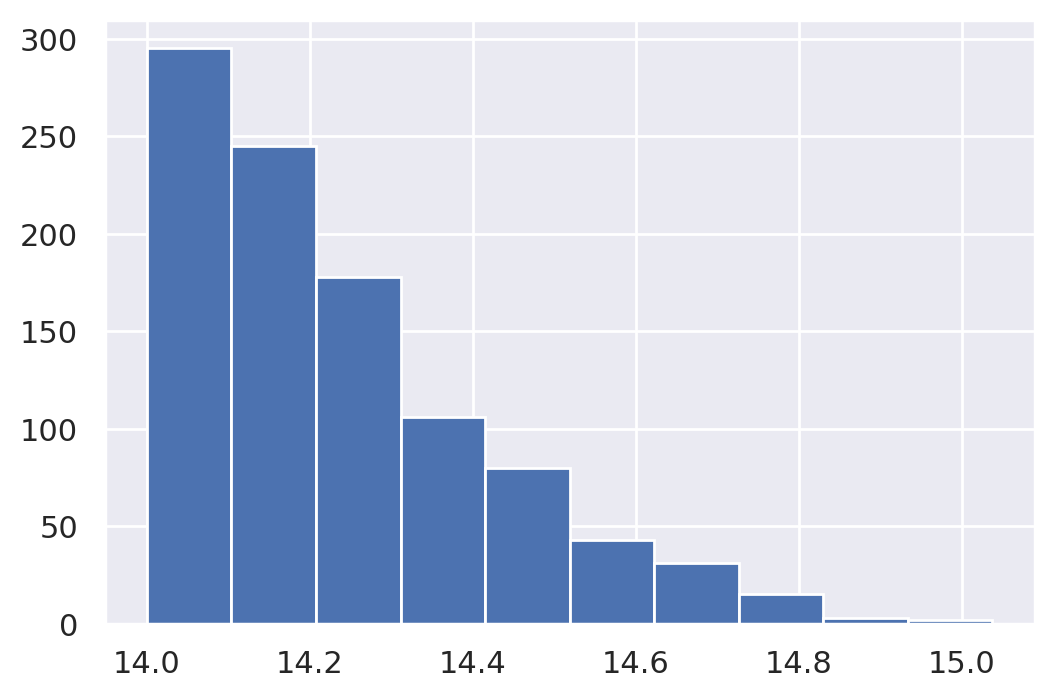

In [23]:
plt.hist(np.log10(df['M'][np.array(df['lambda'])>20]))

In [24]:
### IMPORTANT CELL ###
# set up integration vectors

mvec = np.logspace(13.8, 15.5, 150)
## TURN ON AND OFF THE MVEC TO TES

# lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
# zetavec = np.linspace(1,1.1*np.max(sz_signal),75)

lbdvec = np.linspace(3, 1.2*np.max(np.array(df['lambda'])), 300)
zetavec = np.linspace(1, 1.1*np.max(np.array(df['zeta'])), 150)

print('Vector size')
print(lbdvec.size)
print(zetavec.size)

Vector size
300
150


In [25]:
### IMPORTANT CELL ###
zvec = np.linspace(np.min(np.array(df['z'])), np.max(np.array(df['z'])), 100)
#zvec = np.linspace(np.min(redshift), np.max(redshift), 100)
## zzv, mm = np.meshgrid(zvec, mvec)

# zzv= np.meshgrid(zvec)
## TURN THE ZZV ON AND OFF TO TEST

from scipy import interpolate

In [26]:
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [27]:
def prob_chisi(zeta, sz_signal, eps=1e-12):
    res = np.exp(-(sz_signal-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(x, mean , std, eps=1e-12):
    res = gaussian(x, mean , std)
    return res#np.where(res<eps,0.,res)

In [28]:
alpha = 0.05

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
print(prob_lbd_hat_vec.shape)
print("This is prob_lbd_hat_vec :", prob_lbd_hat_vec)

prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
print(prob_chisi_vec.shape)
print("This is prob_chisi_vec:", prob_chisi_vec)


lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
print(lbd_indices_vec.shape)
#print("This is lbd_indices_vec:", lbd_indices_vec)

zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])
print(zeta_indices_vec.shape)
#print("This is zeta_indices_vec:", zeta_indices_vec)

(321, 300)
This is prob_lbd_hat_vec : [[5.32213880e-79 4.82141076e-75 3.43952985e-71 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.19840975e-78 1.48104340e-74 1.41570983e-70 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.52991142e-82 5.96555682e-80 2.11061573e-77 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.14683632e-78 1.39367691e-74 1.31128496e-70 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.51352658e-79 2.71471071e-75 1.66650936e-71 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.80878580e-79 1.99165123e-75 1.12736100e-71 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(321, 150)
This is prob_chisi_vec: [[1.22358363e-01 1.68307271e-01 2.28224313e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.33743396e-01 1.81556128e-01 2.42486023e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.19942078e-04 2.87924687e-04 7.40211035e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.16700144e-01 1.616227

In [29]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

def log_likelihood_vec2(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_log_likelihood2(theta, ix))
    p = np.array(probs)/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [30]:
def _log_likelihood2(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # forgot the mass
    mass_i = mass[ix]
    #print("This is mass_i:", mass_i)
    
    redshift_i = redshift[ix]
    #print("This is redshift_i:", redshift_i)
    
    p_chisi = prob_chisi_vec[ix]
    #print("This is p_chisi:", p_chisi)
    
    p_lbd_hat = prob_lbd_hat_vec[ix]
    #print("This is p_lbd_hat:", p_lbd_hat)
    
    llo, lup = list(lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    
    #print("This is the list of lbd_indices_vec[ix]:", list(lbd_indices_vec[ix]))
    #print("This is the list of zeta_indices_vec[ix]:", list(zeta_indices_vec[ix]))
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass_i, redshift_i)
    #print("This is ln_lbd_pred before lup,llo,cup,clo:", ln_lbd_pred)
    
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass_i, redshift_i)
    #print("This is ln_zeta_pred before lup,llo,cup,clo:", ln_zeta_pred)
        
    #hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo))).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo))).T
    
    #print("This is ln_lbd_pred after lup,llo,cup,clo:", ln_lbd_pred)
    #print("This is ln_lbd_pred shape:", ln_lbd_pred.shape)
    #print("This is ln_zeta_pred after lup,llo,cup,clo:", ln_zeta_pred)
    #print("This is ln_zeta_pred shape:", ln_zeta_pred.shape)
    
    # compute dn_dlbd_dzeta_integrand
    # Now p_lbd_zeta instead of p_total_m = compute_dn_dlbd_dzeta_vec2
    p_lbd_zeta = compute_dn_dlbd_dzeta_vec2(_lambda_i, _lambda_error_i, sz_signal_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[clo:cup,llo:lup],zz[clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred)
    #print("This is p_lbd_zeta:", p_lbd_zeta)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    #print("This is p_chisi:", p_chisi)
    ## REMOVE ADDITIONAL VALUE OF 1
    
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)
    #print("This is p_lbd after trapezoidal transformation:", p_lbd)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    #print("This is p after trapezoidal transformation:", p)
    return p

In [31]:
def compute_dn_dlbd_dzeta_vec2(_lambda_i, _lambda_error_i, sz_signal_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    #print("This is ln_zeta_pred (1):", ln_zeta_pred)
    #print("This is scatter_sze (2):", scatter_sze)
    #print("This is s_zeta (3):", s_zeta)
    s_zeta_inv = np.where(s_zeta<=eps, -np.inf, 1/s_zeta)
    #print("This is s_zeta_inv:", s_zeta_inv)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    #print("This is ln_lbd_pred (1):", ln_lbd_pred)
    #print("This is scatter_lambda (2):", scatter_lambda)
    #print("This is s_lambda (3):", s_lambda)
    s_lambda_inv = np.where(s_lambda<=eps, -np.inf, 1/s_lambda)
    #print("This is s_lambda_inv:", s_lambda_inv)
    
    cov = (scatter_lambda)**(2)*(scatter_sze)**(2)*(1-rho**2)
    #print("This is cov matrix:", cov)
    additional_cov = (-0.5)*np.log(np.pi*cov**2)
    #print("This is additional_cov:", additional_cov)
    
    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)
    
    lbd_std = (np.log(lvec) - (ln_lbd_pred))*s_lambda_inv
    #print("This is lbd_std:", lbd_std)
    zeta_std = (np.log(zvec)- (ln_zeta_pred))*s_zeta_inv
    #print("This is zeta_std:", zeta_std)
    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2
    #print("This is lp_lbd:", lp_lbd)

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2
    #print("This is lp_zeta:", lp_zeta)
    
    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    #print("This is lp_corr:", lp_corr)

    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    #print("This is lp_total_m:", lp_total_m)
    
    p_total_m = (np.exp(lp_total_m))/(lvec*zvec)
    #print("This is p_total_m:", p_total_m)
    
    return p_total_m

In [32]:
#rho = theta[-1]
#scatter_sze = theta[3]
#scatter_lambda = theta[7]

SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']



def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [33]:
logprior(theta)

0.0

In [34]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, indices, eps=1e-9)

In [35]:
#set_prior_sze([5.24, 1.534, 0.465, 0.161])

In [36]:
Nburnin = 800 # number of burn-in samples
Nsamples = 1600 # number of final posterior samples
walkers = 200
ndims = len(theta)

guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]

In [37]:
logposterior(theta, sel)

-472.5463830104744

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_vec2(*args)
initial = theta + 0.1 * np.random.randn(9)
soln = minimize(nll, initial, args=sel)
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

In [39]:
theta

[5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [40]:
soln.x[-1]

0.9999806724569253

In [41]:
import time
from multiprocessing import Pool
with Pool(processes = 40) as pool:
    sampler = emcee.EnsembleSampler(walkers, ndims, logposterior,args=[np.arange(len(mass))], pool=pool)
    start = time.time()
    sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
    end = time.time()
    multi_time = end - start
    serial_time = (1.5)*(3600)
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

  0%|          | 7/2400 [00:10<1:00:16,  1.51s/it]<ipython-input-29-57ab7007df55>:13: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)
  0%|          | 10/2400 [00:14<56:53,  1.43s/it] <ipython-input-29-57ab7007df55>:13: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)
<ipython-input-29-57ab7007df55>:13: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)
  1%|          | 15/2400 [00:21<54:43,  1.38s/it]<ipython-input-29-57ab7007df55>:13: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)
<ipython-input-29-57ab7007df55>:13: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)
  1%|          | 17/2400 [00:24<53:43,  1.35s/it]<ipython-input-29-57ab7007df55>:13: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)
  1%|          | 19/2400 [00:26<52:31,  1.32s/it]<ipython-input-29-57ab7007df55>:13: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(p)
  1%|      

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:



emcee: Exception while calling your lik

KeyboardInterrupt: 

In [ ]:
#import time
#from multiprocessing import Pool

#pool = Pool(processes=64)              # start 64 worker processes
#sampler = emcee.EnsembleSampler(walkers, ndims, logposterior,args=[np.arange(len(mass))], pool=pool)
#start = time.time()
#sampler.run_mcmc(guess, Nsamples+Nburnin)
#end = time.time()
#multi_time = end - start
#serial_time = (1.5)*(3600)
#print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#print("{0:.1f} times faster than serial".format(serial_time / multi_time))

# Replaced "args=[np.arange(len(mass))]" with "args=argslist"

In [ ]:
flat_samples = sampler.flatchain

In [ ]:
fig, axes = plt.subplots(ndims, figsize=(10, 7), sharex=True)
samples = flat_samples
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
import corner

#fig = corner.corner(
#    flat_samples, truths=theta
#);

fig = corner.corner(
    flat_samples, 
    truths= theta,
    labels=[r"Aλ", r"Bλ", r"Cλ", r"Scatter", r"A_SZE", r"B_SZE", r"C_SZE", r"Scatter_SZE", "ρ"], 
    show_titles = True
);

In [ ]:
#import matplotlib as mpl
#mpl.use("Agg") # force Matplotlib backend to Agg
#import corner
#import corner.py
#except ImportError:
#    sys.exit(1)

In [ ]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

40 CPUs
